In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION: UPDATE THIS PATH ---
# Point this to where you uploaded the zip file in your Drive
ZIP_PATH = '/content/drive/MyDrive/Animals-10.zip'
# ---------------------------------------

# 2. Copy and Unzip to Local Colab Storage
if not os.path.exists('Animals-10'):
    print(f"Copying {ZIP_PATH} to local storage...")
    !cp "{ZIP_PATH}" animals-10.zip
    print("Unzipping...")
    !unzip -q animals-10.zip -d Animals-10
    print("Done.")

# 3. Find Images and Prepare Splits
DATA_DIR = 'Animals-10/raw-img'
if not os.path.exists(DATA_DIR):
    # Fallback to find the folder if the zip structure is different
    for root, dirs, files in os.walk('Animals-10'):
        if 'cane' in dirs:
            DATA_DIR = root
            break

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Classes found: {class_names}")

image_paths = []
labels = []
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for f in os.listdir(class_dir):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, f))
            labels.append(class_to_index[class_name])

# Stratified Split (70% Train, 15% Val, 15% Test) [cite: 120]
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.30, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Class Weights [cite: 121]
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}

print(f"Data ready: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test.")

Mounted at /content/drive
Copying /content/drive/MyDrive/Animals-10.zip to local storage...
Unzipping...
Done.
Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Data ready: 18325 train, 3927 val, 3927 test.


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def process_image_mobilenet(image_path, label):
    # Load and Decode
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)

    # Resize to 224x224
    img = tf.image.resize(img, (224, 224))

    # MobileNetV2 Specific Preprocessing (scales to -1, 1)
    img = preprocess_input(img)

    return img, label

def build_dataset(paths, labels, is_training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache for speed
    ds = ds.cache()

    if is_training:
        ds = ds.shuffle(len(paths))
        # Simple augmentation
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(64) # Batch size 64 usually fits well for MobileNet [cite: 177]
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(X_train, y_train, is_training=True)
val_ds = build_dataset(X_val, y_val)
test_ds = build_dataset(X_test, y_test)
print("MobileNetV2 Pipeline Ready.")

MobileNetV2 Pipeline Ready.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Build Model [cite: 166]
def build_mobilenet_model():
    # Load pre-trained base (weights='imagenet')
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False # Freeze base for Stage 1

    # Add new classifier head
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_mobilenet_model()

# 2. STAGE 1: WARM-UP [cite: 138]
print("\n--- STAGE 1: WARM-UP ---")
model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_1 = ModelCheckpoint('mobile_stage1.keras', save_best_only=True, monitor='val_loss')

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights,
    callbacks=[checkpoint_1]
)

# 3. STAGE 2: FINE-TUNING [cite: 143]
print("\n--- STAGE 2: FINE-TUNING ---")
model.load_weights('mobile_stage1.keras') # Load best from stage 1
model.layers[1].trainable = True # Unfreeze base

# Freeze the bottom layers (MobileNetV2 has ~155 layers, unfreeze top ~30)
for layer in model.layers[1].layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Low LR [cite: 145]

checkpoint_2 = ModelCheckpoint('mobile_best.keras', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint_2, early_stop]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

--- STAGE 1: WARM-UP ---
Epoch 1/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 99s 251ms/step - accuracy: 0.6591 - loss: 1.1264 - val_accuracy: 0.9414 - val_loss: 0.1959
Epoch 2/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 49s 172ms/step - accuracy: 0.8981 - loss: 0.3285 - val_accuracy: 0.9559 - val_loss: 0.1542
Epoch 3/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 50s 175ms/step - accuracy: 0.9131 - loss: 0.2898 - val_accuracy: 0.9585 - val_loss: 0.1386
Epoch 4/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 49s 169ms/step - accuracy: 0.9188 - loss: 0.2724 - val_accuracy: 0.9610 - val_loss: 0.1421
Epoch 5/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 49s 171ms/step - accuracy: 0.9188 - loss: 0.2647 - val_accuracy: 0.9565 - val_loss: 0.1451
Epoch 6/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 49s 172ms/step - accuracy: 0.9197 - loss: 0.2578 - val_accuracy: 0.9595 - val_loss: 0.1391
Epoch 7/10
287/287 ━━━━━━━━━━━━━━━━━━━━ 51s 176ms/step - accuracy: 0.9235 - loss: 0.2444 - val_accuracy: 0.9595 - val_loss: 0.1437
Epoch 8/

Running predictions...
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        cane       0.99      0.96      0.97       730
     cavallo       0.96      0.96      0.96       393
    elefante       0.98      0.99      0.98       217
    farfalla       0.97      0.97      0.97       317
     gallina       0.98      0.97      0.98       465
       gatto       0.95      0.96      0.96       250
       mucca       0.91      0.96      0.93       280
      pecora       0.92      0.96      0.94       273
       ragno       0.99      0.98      0.98       723
  scoiattolo       0.99      0.98      0.98       279

    accuracy                           0.97      3927
   macro avg       0.96      0.97      0.97      3927
weighted avg       0.97      0.97      0.97      3927

Weighted F1-Score: 0.9691


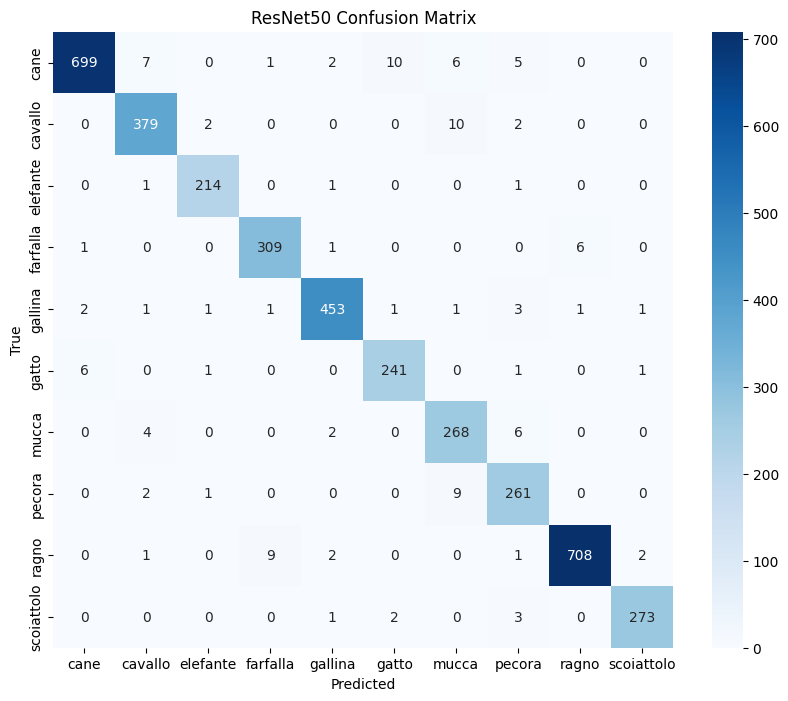

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np

print("Running predictions...")
logits = model.predict(test_ds)
preds = np.argmax(logits, axis=1)

# 2. Metrics
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, preds, target_names=class_names))

weighted_f1 = f1_score(y_test, preds, average='weighted')
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# 3. Confusion Matrix Visualization
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ResNet50 Confusion Matrix')
plt.show()